In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('forestfires.csv')
df = df[df['area'] != 0]

In [252]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61


In [253]:
# сделаем замечание, что основные лесные пожары по разрушимости падают на июль,
# август, сентябрь
df[df['area'] > 100]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
232,6,4,sep,tue,91.0,129.5,692.6,7.0,18.7,43,2.7,0.0,103.39
233,9,4,sep,tue,84.4,73.4,671.9,3.2,24.3,36,3.1,0.0,105.66
234,4,5,sep,sat,92.5,121.1,674.4,8.6,17.7,25,3.1,0.0,154.88
235,8,6,aug,sun,91.4,142.4,601.4,10.6,19.6,41,5.8,0.0,196.48
236,2,2,sep,sat,92.5,121.1,674.4,8.6,18.2,46,1.8,0.0,200.94
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
377,2,2,aug,sat,93.7,231.1,715.1,8.4,21.9,42,2.2,0.0,174.63
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
420,8,8,aug,wed,91.7,191.4,635.9,7.8,26.2,36,4.5,0.0,185.76


,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,classes
138,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36,0
139,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43,1
140,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47,0
141,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55,1
142,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61,1


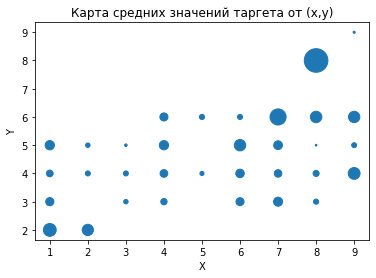

In [254]:
# изобразим карту, которая показывает через размер кружочка среднюю
# площадь повреждений от пожаров в зависимости от координаты (x, y)
dict_for_xy = {}
for xvalue in np.unique(df['X'].values):
  for yvalue in np.unique(df['Y'].values):
    dfpart = df[(df['X'] == xvalue) & (df['Y'] == yvalue)]
    if dfpart.shape[0] >= 1:
      dict_for_xy[(xvalue, yvalue)] = np.mean(dfpart['area'].values)

x, y = [a[0] for a in list(dict_for_xy.keys())], [b[1] for b in list(dict_for_xy.keys())]
z = list(dict_for_xy.values())

plt.scatter(x, y, s = [3*a for a in z])
plt.title('Карта средних значений таргета от (x,y)')
plt.xlabel('X')
plt.ylabel('Y')

# наблюдаем нелинейную зависимость среднего от координаты, поэтому сделаем следующее:
# создадим бинарную переменную по следующей метке: 
# пораженная зона меньше 10 (большинство объектов) или пораженная зона больше 10
# после (X, Y) -> (classes) проведём one-hot-encoding

classes = [0, 1]
to_append = []
for j in range(df.shape[0]):
  coordinates = tuple(df[['X', 'Y']].values[j])
  num = dict_for_xy[coordinates]
  if num < 10:
    to_append.append(classes[0])
  else:
    to_append.append(classes[1])
df = df.drop('X', axis = 1)
df = df.drop('Y', axis = 1)
df['classes'] = to_append

df.head()

In [255]:
# Преобразуем категориальные признаки: по понятным причинам, хотим привести всё 
# к численному виду.
# Создадим дамми - переменные по месяцу (через one-hot) и по дню недели.
# лесные пожары зависят от дня недели в том смысле, выходной это или будний день
# так как в первом случае большую роль в пожарах играет человеческий фактор
# 1 - sunday/saturday, 0 - else
# аналогично бинарную переменную "является ли месяц одни из списка: июль, август, сентябрь"
months = ['aug', 'sep', 'jul']
binary2 = [int(month in months) for month in df['month']]
holiday = ['sun', 'sat']
binary1 = [int(day in holiday) for day in df['day']]
# Дропнем месяц и дни недели
df = df.drop('month',axis = 1)
df = df.drop('day',axis = 1)
# Присоединим созданные выше one-hot матрицы
df['is_holiday'] = binary1
df['is_hottest_months'] = binary2
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,classes,is_holiday,is_hottest_months
138,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36,0,0,1
139,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43,1,0,1
140,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47,0,0,1
141,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55,1,0,1
142,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61,1,0,1


In [256]:
# FFMC - что-то типа про влажность в почве
# DMC - что-то про влажность в дереве
# DC - почти дублирует DMC
# ISI - комбинация FFMC и wind-фактора, иллюстрирует скорость распространения 

In [257]:
df[['FFMC', 'DMC', 'DC', 'ISI']].corr()

,FFMC,DMC,DC,ISI
FFMC,1.000000,0.480250,0.407638,0.704170
DMC,0.480250,1.000000,0.668926,0.329656
DC,0.407638,0.668926,1.000000,0.256826
ISI,0.704170,0.329656,0.256826,1.000000


In [258]:
# видим, что все эти показатели коррелируют. 
# было бы классно их объединить, как минимум, чтобы было попроще интерпретировать результаты
# воспользуемся методом PCA, объединив эти 4 индекса в один абстрактный
# назовём его all_indexes
# P.S. только изменим ISI, взяв все значения с отрицательным знаком, т.к.
# этот индекс, в отличие от других, положительно влияет на размер area
from sklearn.decomposition import IncrementalPCA
neg_isi = -df['ISI'].values
df = df.drop('ISI', axis = 1)
df['ISI'] = neg_isi
df_to_tr = df[['FFMC', 'DMC', 'DC', 'ISI']]
ipca = IncrementalPCA(n_components=1)
ipca.fit(df_to_tr)
new_column = ipca.transform(df_to_tr)


In [259]:
df = df.drop(['FFMC', 'DMC', 'DC', 'ISI'],axis = 1)
df['all_indexes'] = new_column
df.head()

,temp,RH,wind,rain,area,classes,is_holiday,is_hottest_months,all_indexes
138,18.0,42,2.7,0.0,0.36,0,0,1,-265.320971
139,21.7,38,2.2,0.0,0.43,1,0,1,122.370404
140,21.9,39,1.8,0.0,0.47,0,0,1,115.824104
141,23.3,31,4.5,0.0,0.55,1,0,1,-59.254211
142,21.2,51,8.9,0.0,0.61,1,0,1,-41.590414


In [260]:
# остальные показатели оставим в норме, так как они хорошие вещественные, (нецелевые)
# temp - температура
# rh - относительная влажность
# wind - скорость ветра
# rain - обильность дождя в милиметрах на кв.метр

Text(0, 0.5, 'Частота появлений')

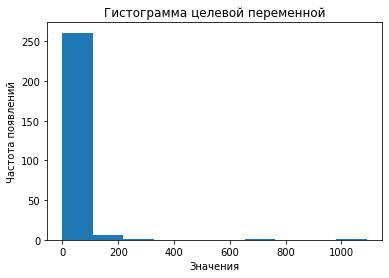

In [261]:
# изобразим гистограмму целевой переменной. видим, что было бы неплохо прологарифмировать
# целевую переменную
plt.hist(df['area'])
plt.title('Гистограмма целевой переменной')
plt.xlabel('Значения')
plt.ylabel('Частота появлений')

Text(0, 0.5, 'Частота появлений')

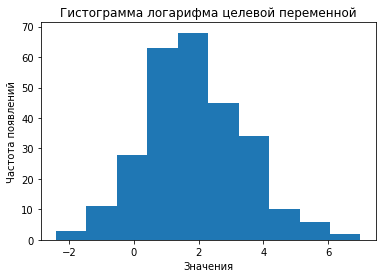

In [262]:
### да, и вправду было бы неплохо
plt.hist(np.log(df['area'].values))
plt.title('Гистограмма логарифма целевой переменной')
plt.xlabel('Значения')
plt.ylabel('Частота появлений')

In [263]:
to_change = np.log(df['area'].values)
df = df.drop('area', axis = 1)
df['log_area'] = to_change
df.head()

,temp,RH,wind,rain,classes,is_holiday,is_hottest_months,all_indexes,log_area
138,18.0,42,2.7,0.0,0,0,1,-265.320971,-1.021651
139,21.7,38,2.2,0.0,1,0,1,122.370404,-0.843970
140,21.9,39,1.8,0.0,0,0,1,115.824104,-0.755023
141,23.3,31,4.5,0.0,1,0,1,-59.254211,-0.597837
142,21.2,51,8.9,0.0,1,0,1,-41.590414,-0.494296


Text(0, 0.5, 'Частота появлений')

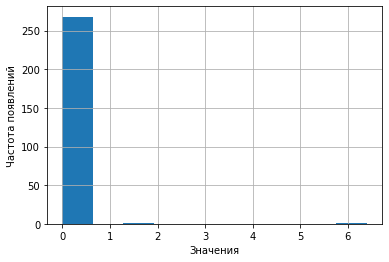

In [264]:
# будем брать все признаки, которые описаны выше, кроме переменной rain, 
# так как было достаточно мало дождливых дней, и в основном rain принимает значения 0
# смотрим на гистограмму ниже
# взятие признаков мотивировали выше, пока их преобразовывали
# ещё стоит сказать, что очевидными кажутся с ковбойской точки зрения
# переменные температуры, влажности и скорости ветра (ну тут обойдёмся без описания)
# (ну, и как будет видно, придется избавиться от is_hottest_months, но пока
# включим её)
# ожидаем положительный коэф у temp (чем жарче, тем суше и т.д.)
# ожидаем отрицательный коэф у rh (чем влажнее, тем меньше шанс возгорания чего-либо)
# ожидаем положительный коэф у wind (влияет на скорость распространния ветра)
# ожидаем положительный коэф у classes (попадаем в зоны, где чаще и больше горит)
# ожидаем положительный коэф у is_holiday (больше человеческий фактор)
# ожидаем положительный коэф у is_hottest_months (как и с температурой)
# ожидаем отрицательный коэф у all_indexes (устроены по смыслу так, что чем они больше, тем больше влаги и т.д.)

df['rain'].hist()
plt.xlabel('Значения')
plt.ylabel('Частота появлений')

In [265]:
df = df.drop('rain', axis = 1)

In [266]:
### для каждого столбца сохраним список из [среднее, медиана, дисперсия, минимум, максимум]
dict_of_statistics = {}
for values in df.columns:
  val_array = df[values].values
  vmean = np.mean(val_array)
  vmedian = np.median(val_array)
  vvar = np.var(val_array)
  vmax = np.max(val_array)
  vmin = np.min(val_array)
  dict_of_statistics[values] = [vmean, vmedian, vvar, vmax, vmin]

In [267]:
dict_of_statistics

{'RH': [43.733333333333334, 41.0, 226.5659259259259, 96, 15],
 'all_indexes': [4.5474735088646414e-14,
  92.81879180117872,
  54469.222418898695,
  317.0871381563081,
  -566.6093656373989],
 'classes': [0.725925925925926, 1.0, 0.19895747599451305, 1, 0],
 'is_holiday': [0.3296296296296296, 0.0, 0.2209739368998628, 1, 0],
 'is_hottest_months': [0.7925925925925926, 1.0, 0.16438957475994517, 1, 0],
 'log_area': [1.8448310869668947,
  1.8515982373543647,
  2.322217796601119,
  6.9947033206327935,
  -2.4079456086518722],
 'temp': [19.31111111111111, 20.1, 38.0440987654321, 33.3, 2.2],
 'wind': [4.112962962962963, 4.0, 3.538461591220851, 9.4, 0.4]}

                                         Гистограммы


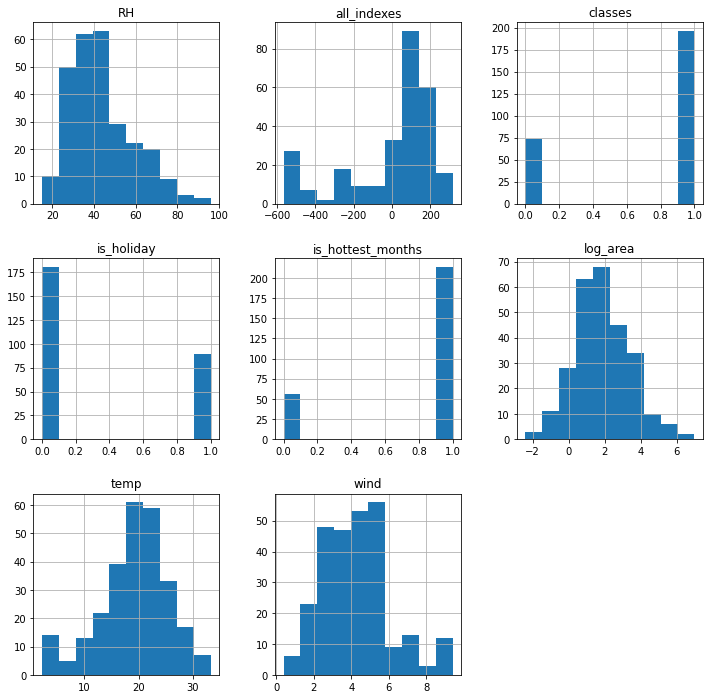

In [268]:
### построим гистограммы по всем столбцам:
print('                                         Гистограммы')
df.hist(figsize = (12, 12));

                           Усики для температуры, ветра и таргета


Text(0, 0.5, 'Значения')

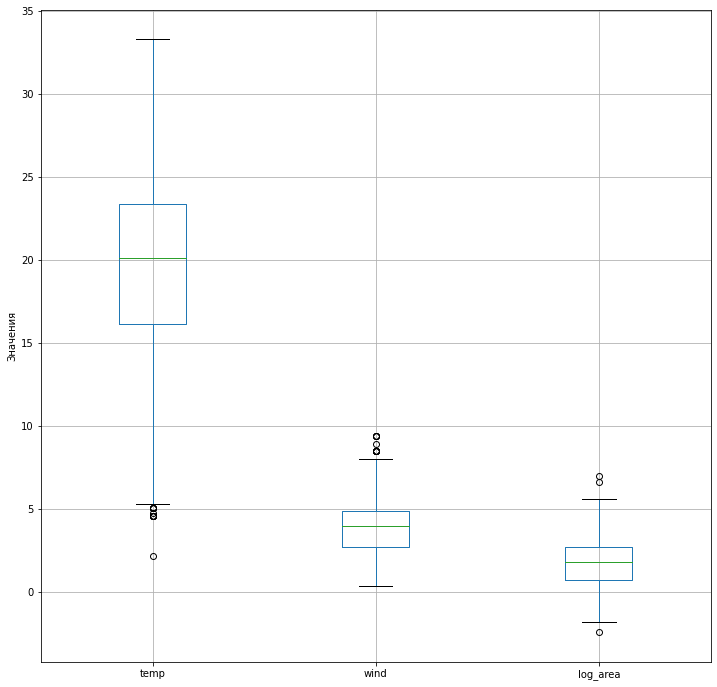

In [269]:
print('                           Усики для температуры, ветра и таргета')
df.boxplot(figsize = (12, 12), column = ['temp', 'wind', 'log_area']);
plt.ylabel('Значения')

                           Усики для дамми-переменных


Text(0, 0.5, 'Значения')

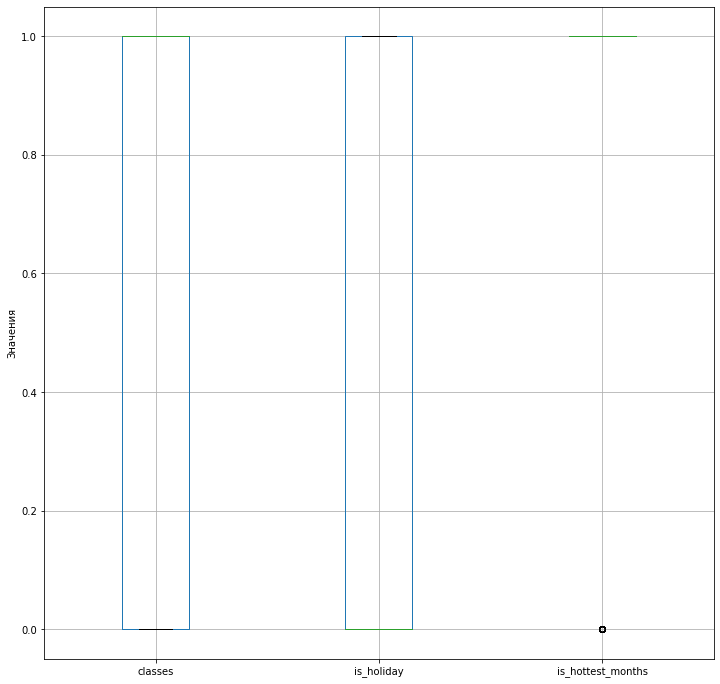

In [270]:
print('                           Усики для дамми-переменных')
df.boxplot(figsize = (12, 12), column = ['classes', 'is_holiday', 'is_hottest_months']);
plt.ylabel('Значения')

                           Усики для остального


Text(0, 0.5, 'Значения')

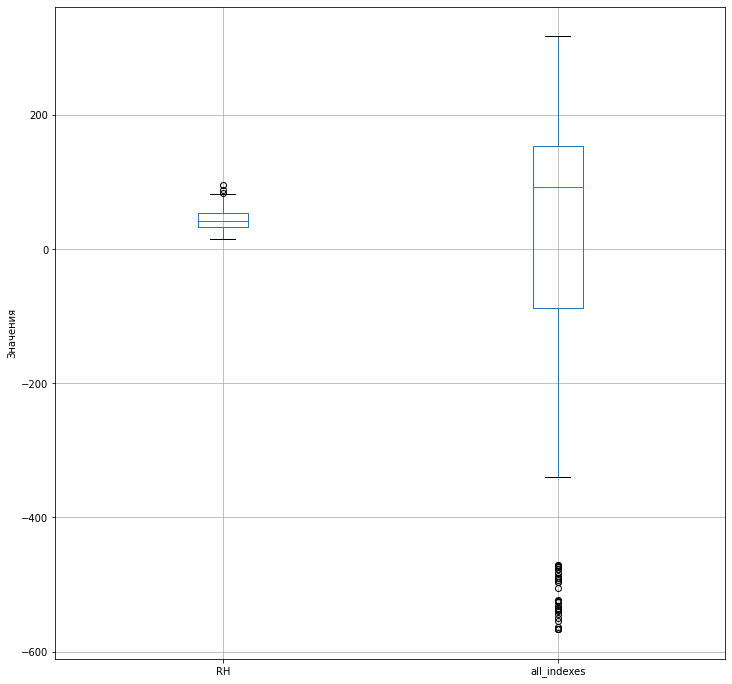

In [271]:
print('                           Усики для остального')
df.boxplot(figsize = (12, 12), column = ['RH', 'all_indexes']);
plt.ylabel('Значения')

In [272]:
# графики выше - норм, мы в принципе отобрали все хорошие признаки
# Проверим с помощью VIF мультиколлинеарность
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

wow = df.drop('log_area', axis = 1)

pd.Series([variance_inflation_factor(wow.values, i) 
               for i in range(wow.shape[1])], 
              index=wow.columns)

temp                 12.831082
RH                    8.610724
wind                  5.394945
classes               3.277419
is_holiday            1.540730
is_hottest_months    19.570451
all_indexes           2.893444
dtype: float64

In [273]:
# неудивительно, что они создают проблему коллениарности, т.к. очевидно, что
# температура кореллирует с месяцем
# т.к. в температуре содержится больше информации, удалим столбец с месяцем
# увидим, и вправду от проблемы избавились
wow1 = df.drop(['log_area', 'is_hottest_months'], axis = 1)

pd.Series([variance_inflation_factor(wow1.values, i) 
               for i in range(wow1.shape[1])], 
              index=wow1.columns)

temp           5.358928
RH             6.352697
wind           5.385281
classes        3.277414
is_holiday     1.539969
all_indexes    1.244481
dtype: float64

In [274]:
from statsmodels.regression.linear_model import OLS
# Проверим ещё и с помощью СN мультиколлинеарность
# Для этого построим регрессию и посмотрим на число обусловленности

target = df['log_area']
data = df.drop(['log_area'], axis=1)
mnk = OLS(target, data)
to_fit = mnk.fit()
to_fit.condition_number

1160.3671806571097

In [275]:
target = df['log_area']
data = df.drop(['log_area', 'is_hottest_months'], axis=1)
mnk = OLS(target, data)
to_fit = mnk.fit()
to_fit.condition_number

505.2493740076525

In [276]:
# Как видно выше, оно находится в разумных пределах, и проблема мультиколлинеарности
# не возникает, если, как и в случае с VIF, выкинуть столбец с месяцем. 
# Посмотрим на описание результатов такой регрессии.
to_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               log_area   R-squared (uncentered):                   0.619
Model:                            OLS   Adj. R-squared (uncentered):              0.610
Method:                 Least Squares   F-statistic:                              71.44
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    1.74e-52
Time:                        15:24:29   Log-Likelihood:                         -488.46
No. Observations:                 270   AIC:                                      988.9
Df Residuals:                     264   BIC:                                      1011.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temp            0.0297      0.010      2.865      0.005       0.009       0.050
RH              0.0014      0.005      0.290      0.772      -0.008       0.011
wind            0.0931      0.047      1.995      0.047       0.001       0.185
classes         0.9155      0.193      4.739      0.000       0.535       1.296
is_holiday      0.4174      0.197      2.124      0.035       0.030       0.804
all_indexes    -0.0003      0.000     -0.704      0.482      -0.001       0.001
==============================================================================
Omnibus:                        0.422   Durbin-Watson:                   1.031
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.256
Skew:                           0.064   Prob(JB):                        0.880
Kurtosis:                       3.080   Cond. No.                         505.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [277]:
# знак не совпал с RH (скорее всего, логика как с rain - в основном, засушливые дни
# в итоге незначимый) и с all_indexes (тут он прост не значим, если ещё каждый изначальный индекс
# взять и посмотреть на его корреляцию с таргетом - там будет она оч низкая, так что
# просто индекс оказался не очень :) )
# Выбросим незначимые регрессоры RH и all_indexes для красоты и построим новую регрессию
target = df['log_area']
data = df.drop(['log_area', 'is_hottest_months', 'RH', 'all_indexes'], axis=1)
mnk = OLS(target, data)
to_fit = mnk.fit()
to_fit.condition_number
to_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               log_area   R-squared (uncentered):                   0.618
Model:                            OLS   Adj. R-squared (uncentered):              0.612
Method:                 Least Squares   F-statistic:                              107.6
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    2.16e-54
Time:                        15:24:29   Log-Likelihood:                         -488.77
No. Observations:                 270   AIC:                                      985.5
Df Residuals:                     266   BIC:                                      999.9
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0277      0.009      3.101      0.002       0.010       0.045
wind           0.1098      0.038      2.864      0.005       0.034       0.185
classes        0.9439      0.183      5.146      0.000       0.583       1.305
is_holiday     0.4375      0.193      2.268      0.024       0.058       0.817
==============================================================================
Omnibus:                        0.235   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.100
Skew:                           0.036   Prob(JB):                        0.951
Kurtosis:                       3.062   Cond. No.                         44.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [278]:
# Теперь всё крссиво, все коэфы значимы и модель тоже сама значима (prob f-st ~ 0)
# Остатки нормальные (J-B сверху), но проигнорируем это 
# ради доп. балла и проделаем процедуру на бонус
# 10000 раз выберем случайно 30 наблюдений, построим на них регрессию, получим
# таким образом 1000 сэмплов для каждого коэффициента. Построим для каждого доверительные
# интервалы на 5%
spisok = np.zeros(1000*4).reshape(1000, 4)
for j in range(1000):
  df3 = df.sample(30)
  target3 = df3['log_area']
  data3 = df3.drop(['log_area', 'is_hottest_months', 'RH', 'all_indexes'], axis=1)
  mnk3 = OLS(target3, data3)
  to_fit3 = mnk3.fit()
  to_fit3.condition_number
  spisok[j] = list(to_fit3.params)

In [279]:
for i in range(4):
  samples = spisok[:, i]
  left_c = np.mean(samples) - 1.96 * np.std(samples)/(1000**(1/2)) 
  right_c = np.mean(samples) + 1.96 * np.std(samples)/(1000**(1/2))
  print('Conf. inteval for '+data3.columns[i]+' is: [' + str(left_c) +'; ' + str(right_c) + ']')

Conf. inteval for temp is: [0.02671454694410365; 0.029706415985277197]
Conf. inteval for wind is: [0.09894711026515304; 0.11318541934387111]
Conf. inteval for classes is: [0.9087832698769129; 0.9746377872796459]
Conf. inteval for is_holiday is: [0.41916340363015275; 0.4944328705026892]


In [280]:
# выберем медианный объект, выведим для него точечный прогноз (predict на обученных коэфах)
# теперь построим доверительные интервалы (инд. и средний прогноз)
# имея в виду, что статистики распределены по стьюденту с (270 - 4) степенями свободы

median_object = df.drop(columns = ['log_area', 'is_hottest_months', 'RH', 'all_indexes']).median().values
pret = np.exp(to_fit.get_prediction(median_object).summary_frame().values)[0]
print('Точечный: ' + str(pret[0]))
print('Индивидуальный: ', (pret[-1], pret[-2]))
print('Для среднего: ', (pret[2], pret[3]))


Точечный: 6.952833284402458
Индивидуальный:  (132.07041527451372, 0.3660311855627477)
Для среднего:  (5.422993995659587, 8.91424381428159)


                                           Квадраты ошибок в зависимости от значений переменных-признаков


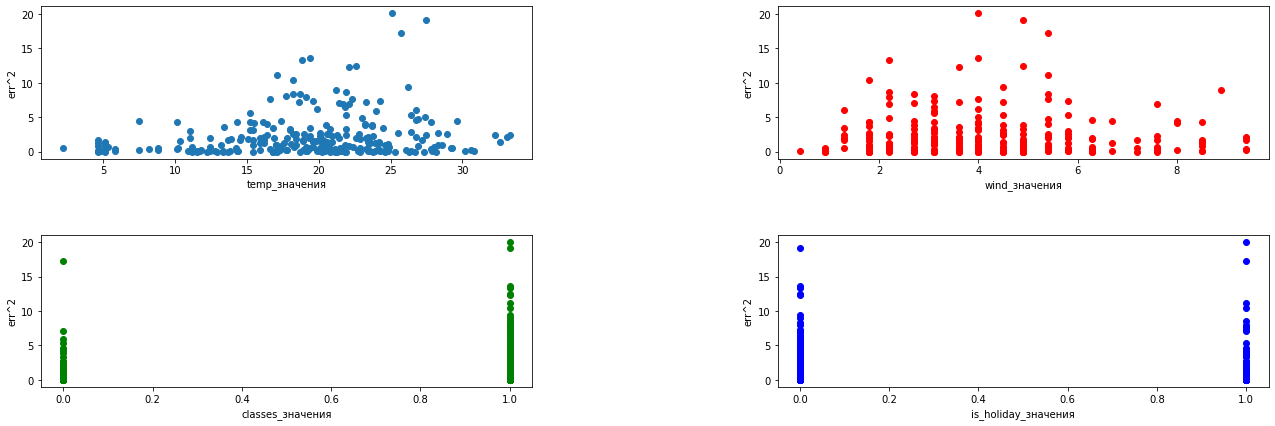

In [281]:
errors = (target - to_fit.predict())**2
errors
print('                                           Квадраты ошибок в зависимости от значений переменных-признаков')
fig = plt.figure(figsize = (22, 7))

plt.subplot(2, 2, 1)
plt.scatter(df['temp'], errors)
plt.xlabel('temp_значения')
plt.ylabel('err^2')
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

plt.subplot(2, 2, 2)
plt.scatter(df['wind'], errors, c = 'r')
plt.xlabel('wind_значения')
plt.ylabel('err^2')

plt.subplot(2, 2, 3)
plt.scatter(df['classes'], errors, c ='g')
plt.xlabel('classes_значения')
plt.ylabel('err^2')

plt.subplot(2, 2, 4)
plt.scatter(df['is_holiday'], errors, c='b')
plt.xlabel('is_holiday_значения')
plt.ylabel('err^2')


plt.show()

In [282]:
# Графическое предположение: у всех переменных, кроме is_holiday, наблюдается
# гетероскедастичность (не оч. большая, поэтому вряд ли это что-то значимое,
# проверим потом черед Г-К)
# у temp и wind - параболовидная ветвями вниз (+-), у classes - большой разброс
# для значения 1 и намного меньше для 0. Проведём тест Г-К:
from statsmodels.stats.diagnostic import het_goldfeldquandt
for column in data.columns:
  test = het_goldfeldquandt(errors, data[column].values.reshape(-1, 1))
  print('Для колонки '+column+': F-статистика - ' + str(test[0]) + ', p-values - ' + str(test[1]))

Для колонки temp: F-статистика - 0.7032113285989812, p-values - 0.9787661399055647
Для колонки wind: F-статистика - 0.6239147781513864, p-values - 0.996664695028014
Для колонки classes: F-статистика - 0.5985908326286129, p-values - 0.9984043871510571
Для колонки is_holiday: F-статистика - 0.6434663526294411, p-values - 0.9944075610586651


In [283]:
# Гипотеза о равенстве дисперсий не отвергается, поэтому тест Г-К не выявляет гетероскедастичность
# Результаты могут по двум причинам не совпадать: либо мы просто имели дело на графике с
# выбросами, на которые можно забить, либо дело в том, что из-за параболовидной формы
# при делении выборки на 2 части не учитывается эта <<серединка>>

In [284]:
# Для взвешенного МНК используем HC0:
# результаты  не сильно поменялись, что и логично, так как
# тесты на гетероскедастичность показали хороший результат
# тем не менее, std у коэфов поменялся немножко, что и следовало ожидать
# p.s. кстати, коэфы стали менее значимыми (кроме последнего), но это, опять-таки
# не значительные изменения
# аналогичные выводы ниже для HC3 (там изменения поменьше)

wnk = OLS(target, data)
to_fit_hc0 = wnk.fit()
to_fit_hc0.get_robustcov_results(cov_type = "HC0").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               log_area   R-squared (uncentered):                   0.618
Model:                            OLS   Adj. R-squared (uncentered):              0.612
Method:                 Least Squares   F-statistic:                              97.41
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    6.27e-51
Time:                        15:24:32   Log-Likelihood:                         -488.77
No. Observations:                 270   AIC:                                      985.5
Df Residuals:                     266   BIC:                                      999.9
Df Model:                           4                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0277      0.007      3.707      0.000       0.013       0.042
wind           0.1098      0.034      3.237      0.001       0.043       0.177
classes        0.9439      0.165      5.725      0.000       0.619       1.268
is_holiday     0.4375      0.198      2.207      0.028       0.047       0.828
==============================================================================
Omnibus:                        0.235   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.100
Skew:                           0.036   Prob(JB):                        0.951
Kurtosis:                       3.062   Cond. No.                         44.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [285]:
# Для взвешенного МНК используем HC3:
wnk = OLS(target, data)
to_fit_hc3 = wnk.fit()
to_fit_hc3.get_robustcov_results(cov_type = "HC3").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               log_area   R-squared (uncentered):                   0.618
Model:                            OLS   Adj. R-squared (uncentered):              0.612
Method:                 Least Squares   F-statistic:                              94.58
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    6.29e-50
Time:                        15:24:32   Log-Likelihood:                         -488.77
No. Observations:                 270   AIC:                                      985.5
Df Residuals:                     266   BIC:                                      999.9
Df Model:                           4                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0277      0.008      3.638      0.000       0.013       0.043
wind           0.1098      0.035      3.165      0.002       0.041       0.178
classes        0.9439      0.168      5.624      0.000       0.613       1.274
is_holiday     0.4375      0.201      2.173      0.031       0.041       0.834
==============================================================================
Omnibus:                        0.235   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.100
Skew:                           0.036   Prob(JB):                        0.951
Kurtosis:                       3.062   Cond. No.                         44.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [286]:
# попробуем уменьшить пространство (ожидания: будет фигня, так как)
# мы уже делали pca и уже у нас достаточно суженное признаковое пространство
# половина переменных - дамми
# ниже видно долю объяснённой дисперсии каждой компонентой
# Коэффициенты супер-незначимые, модель отстой

pca_final = IncrementalPCA(n_components=2)
to_fit_pca = pca_final.fit_transform(data)
print(pca_final.explained_variance_ratio_)
pca_ols = OLS(target, to_fit_pca)
model_pca_ols  = pca_ols.fit()
model_pca_ols.summary()

[0.91539336 0.07481913]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               log_area   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.006
Method:                 Least Squares   F-statistic:                             0.1764
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                       0.838
Time:                        15:24:32   Log-Likelihood:                         -618.50
No. Observations:                 270   AIC:                                      1241.
Df Residuals:                     268   BIC:                                      1248.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0089      0.024     -0.376      0.707      -0.055       0.038
x2             0.0379      0.082      0.460      0.646      -0.124       0.200
==============================================================================
Omnibus:                        6.138   Durbin-Watson:                   0.377
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.870
Skew:                           0.323   Prob(JB):                       0.0531
Kurtosis:                       3.322   Cond. No.                         3.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [287]:
# метод максимального правдоподобия даёт результат как МНК аналитически
# видим, что и вправду всё чики-бамбони совпадает
from numpy.linalg import inv, det
X = data
Xt = data.T
betas = (inv((Xt.dot(X))).dot(Xt)).dot(target)
betas, np.array(to_fit.params)

(array([0.0276696 , 0.1097808 , 0.94386713, 0.43752798]),
 array([0.0276696 , 0.1097808 , 0.94386713, 0.43752798]))

In [288]:
data_f = data.values
target_f = target.values.reshape(-1, 1)
# теперь задача с градиентом
# запишем в начале функцию логарифма правдоподобия для пары (x, y)
# со знаком минус (чтобы минимизировать)
# если положить сигму равную 1, то получим функционал как в МНК
def like_log(X, Y, B):
  return(((Y-X.dot(B)).T).dot(Y-X.dot(B)))[0][0]
# инициализируем веса единицами 
# на каждом шаге по к каждому весу будем поочередно прибавлять дельта, смотреть 
# на изменение like_log и делить на дельту (~ вычисление частных производных)
# так, будет найден приближенный градиент. А дальше обычный спуск
def count_dif(X, Y, B, delta):
  pr = np.zeros(4).reshape(-1, 1)
  for j in range(B.shape[0]):
    B_new = B.copy()
    B_new[j][0] = B[j][0] + delta
    pr[j] = (like_log(X, Y, B_new) - like_log(X, Y, B))/delta
  return(pr)

learning_rate = 0.0000005
delta = 0.0001
not_converged = True
B = np.ones(4).reshape(-1, 1)

while not_converged:
  B -= learning_rate * count_dif(data_f, target_f, B, delta = delta)
  if np.sum((learning_rate * count_dif(data_f, target_f, B, delta = delta))**2)**(1/2) < 0.000001:
    break

In [289]:
# как видно выше, веса с помощью такой апроксимации сходятся почти что с точностью
# до сотых-тысячных, результаты оч похожи, всё круто!
B.reshape(1, -1), np.array(to_fit.params)

(array([[0.0273479 , 0.10993731, 0.94258724, 0.45529613]]),
 array([0.0276696 , 0.1097808 , 0.94386713, 0.43752798]))